In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/campaign_data.csv
/kaggle/input/test.csv
/kaggle/input/Schema.png
/kaggle/input/train.csv
/kaggle/input/customer_transaction_data.csv
/kaggle/input/customer_demographics.csv
/kaggle/input/item_data.csv
/kaggle/input/smote.csv
/kaggle/input/coupon_item_mapping.csv
/kaggle/input/final_train.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
import pandas_profiling
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import auc

import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',500)
pd.set_option('display.max_columns',5000)

encoder = LabelEncoder()
from IPython.display import Image
import os
!ls ../input/

Schema.png		   customer_transaction_data.csv  test.csv
campaign_data.csv	   final_train.csv		  train.csv
coupon_item_mapping.csv    item_data.csv
customer_demographics.csv  smote.csv


In [3]:
train = pd.read_csv('../input/train.csv')
campaign = pd.read_csv('../input/campaign_data.csv')
items = pd.read_csv('../input/item_data.csv')
coupons = pd.read_csv('../input/coupon_item_mapping.csv')
cust_demo = pd.read_csv('../input/customer_demographics.csv')
cust_tran = pd.read_csv('../input/customer_transaction_data.csv')
test = pd.read_csv('../input/test.csv')
df=pd.read_csv('../input/final_train.csv')
data=pd.read_csv('../input/smote.csv')

In [4]:
train.shape, campaign.shape, items.shape, coupons.shape, cust_demo.shape, cust_tran.shape, test.shape,df.shape,data.shape

((78369, 5),
 (28, 4),
 (74066, 4),
 (92663, 2),
 (760, 7),
 (1324566, 7),
 (50226, 4),
 (78369, 43),
 (155280, 42))

In [5]:
print('Train Dataframe')
print(train.isnull().sum())
print('======================')
print('Campaign Dataframe')
print(campaign.isnull().sum())
print('======================')
print('Items Dataframe')
print(items.isnull().sum())
print('======================')
print('Coupons Dataframe')
print(coupons.isnull().sum())
print('======================')
print('Customer Demographics Dataframe')
print(cust_demo.isnull().sum())
print('======================')
print('Customer Transaction Dataframe')
print(cust_tran.isnull().sum())
print('======================')

print(test.isnull().sum())
print('======================')
print(df.isnull().sum())
print('======================')
print(data.isnull().sum())

Train Dataframe
id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64
Campaign Dataframe
campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64
Items Dataframe
item_id       0
brand         0
brand_type    0
category      0
dtype: int64
Coupons Dataframe
coupon_id    0
item_id      0
dtype: int64
Customer Demographics Dataframe
customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64
Customer Transaction Dataframe
date               0
customer_id        0
item_id            0
quantity           0
selling_price      0
other_discount     0
coupon_discount    0
dtype: int64
id             0
campaign_id    0
coupon_id      0
customer_id    0
dtype: int64
Unnamed: 0             0
coupon_id              0
customer_id            0
redemption_status      0
brand                  

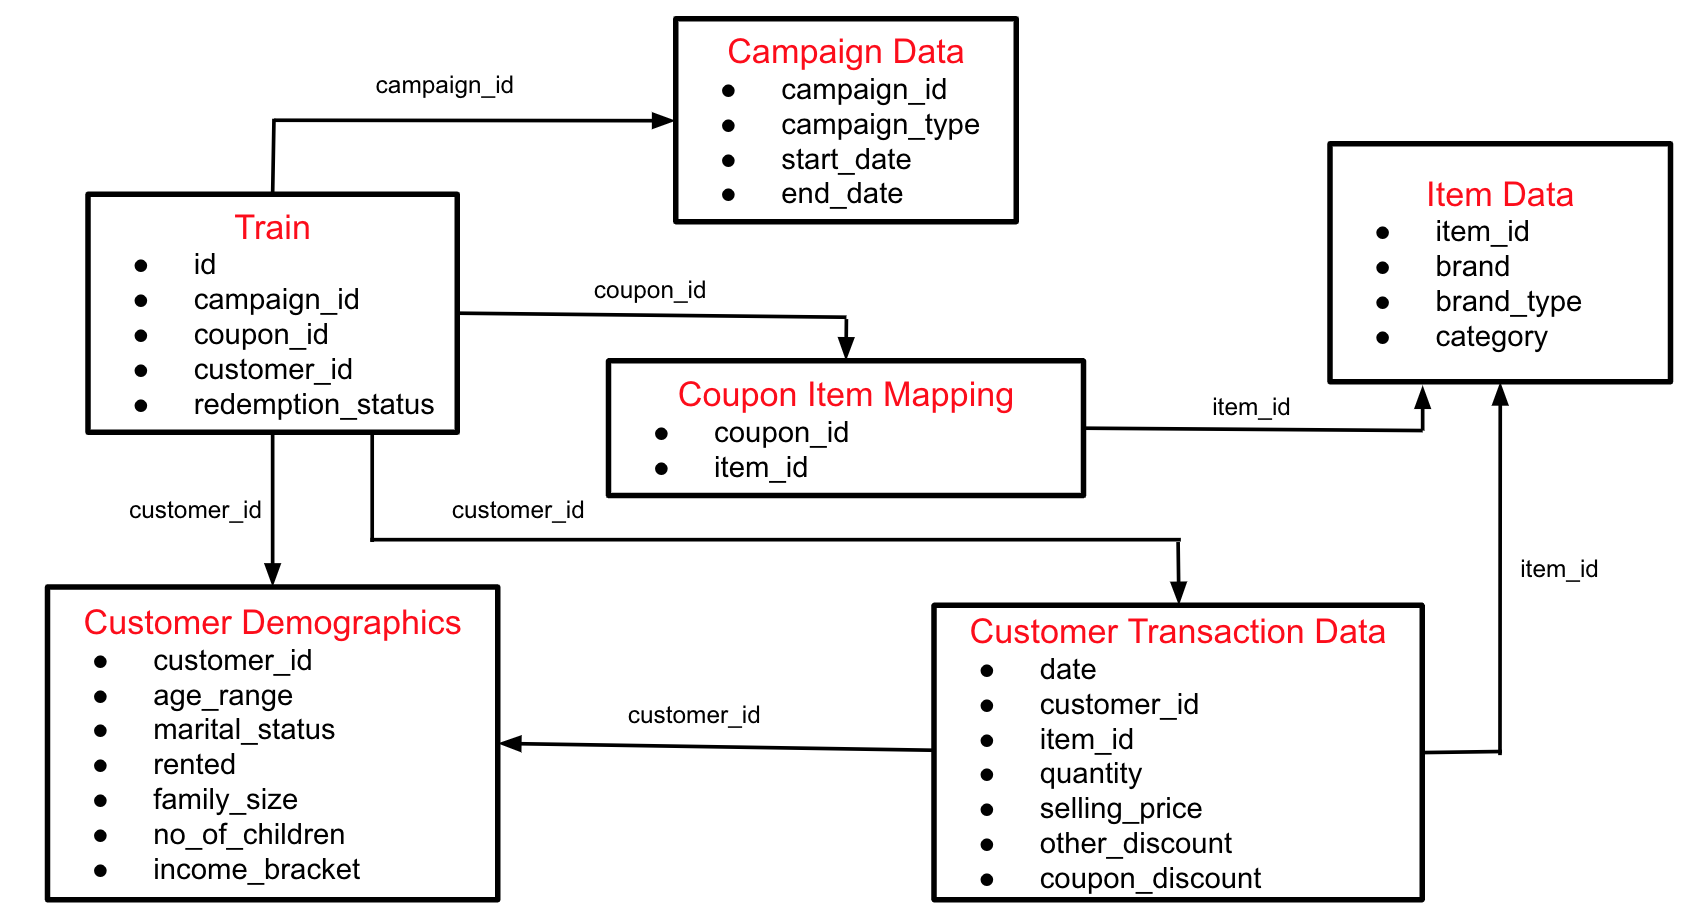

In [6]:
Image("../input/Schema.png")

All datasets merged by following steps:

1. Merge coupon item data and items data on item_id
2. Aggregate transactions by item_id
3. Merge 1 and 2 on item_id
4. Aggregate 3 on coupon_id
5. Merge 4 and train on coupon_id
6. Aggregate transactions on customer_id
7. Merge 5 with campaign data on campaign_id
8. Merge 7 with customer demographic data on customer_id
9. Merge 6 with 8 on customer_id respectively

In [7]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head()

,coupon_id,customer_id,redemption_status,brand,brand_type,category,cd_sum,coupon_discount_x,coupon_used_x,item_counts,no_of_customers,od_sum,other_discount_x,price_sum,qu_sum,quantity_x,selling_price_x,t_counts,total_discount_mean,total_discount_sum,campaign_type,campaign_duration,age_range,marital_status,rented,family_size,no_of_children,income_bracket,coupon_discount_y,coupon_used_y,day,dow,no_of_items,month,other_discount_y,quantity_y,selling_price_y,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,27,1053,0,1105,0,6,-5349.93,-1.241694,191.0,125,19.224000,-177447.090167,-44.367382,436274.446738,4661.0,1.169768,117.276864,3713.0,-45.609077,-182797.020167,0,47,3.0,1.0,0.0,1.0,0.0,5.0,-0.287258,1,11,2,208,5,-25.583099,340.487097,163.966826,-89.05,310,-7930.760842,105551,50829.715972
1,116,48,0,56,1,6,0.00,0.000000,0.0,3,20.333333,-586.140000,-10.207037,5323.510000,86.0,1.050926,70.885046,75.0,-10.207037,-586.140000,0,47,2.0,0.0,0.0,2.0,0.0,3.0,-3.215039,12,4,5,244,6,-20.013685,31.540260,188.638474,-1237.79,385,-7705.268702,12143,72625.812434
2,635,205,0,560,0,11,-605.54,-2.987321,15.0,67,1.761194,-12475.083333,-76.767366,48980.998333,202.0,1.353802,342.826195,142.0,-79.754687,-13080.623333,1,32,3.0,0.0,0.0,2.0,0.0,7.0,-2.212082,85,27,2,533,3,-12.873370,1.392784,112.067666,-2145.72,970,-12487.169143,1351,108705.636349
3,644,1050,0,611,0,6,-17.81,-4.452500,1.0,4,3.500000,-260.750000,-4.451964,3697.783333,47.0,1.110390,88.694903,39.0,-8.904464,-278.560000,0,47,3.0,0.0,0.0,2.0,0.0,5.0,-0.751477,2,9,4,216,8,-12.880868,1.291139,100.896997,-178.10,237,-3052.765833,306,23912.588333
4,1017,1489,0,1558,0,6,-569.92,-0.198055,23.0,32,27.312500,-46796.046667,-30.665116,289181.848333,1610.0,1.071044,200.991719,1420.0,-30.863170,-47365.966667,0,48,3.0,0.0,0.0,2.0,0.0,3.0,-0.471548,10,2,4,327,5,-12.264174,247.443060,85.016352,-265.01,562,-6892.466021,139063,47779.189609


In [8]:
df.shape

(78369, 42)

In [9]:
df.columns

Index(['coupon_id', 'customer_id', 'redemption_status', 'brand', 'brand_type',
       'category', 'cd_sum', 'coupon_discount_x', 'coupon_used_x',
       'item_counts', 'no_of_customers', 'od_sum', 'other_discount_x',
       'price_sum', 'qu_sum', 'quantity_x', 'selling_price_x', 't_counts',
       'total_discount_mean', 'total_discount_sum', 'campaign_type',
       'campaign_duration', 'age_range', 'marital_status', 'rented',
       'family_size', 'no_of_children', 'income_bracket', 'coupon_discount_y',
       'coupon_used_y', 'day', 'dow', 'no_of_items', 'month',
       'other_discount_y', 'quantity_y', 'selling_price_y', 'cdd_sum',
       'customer_id_count', 'odd_sum', 'qa_sum', 'pprice_sum'],
      dtype='object')

In [10]:
from imblearn.over_sampling import SMOTE

# Separate input features and target
y = df.redemption_status
x = df.drop('redemption_status', axis=1)

# Standardizig the Data
col_names = ['cd_sum','coupon_discount_x', 'coupon_used_x', 'item_counts', 'no_of_customers',
       'od_sum', 'other_discount_x', 'price_sum', 'qu_sum', 'quantity_x',
       'selling_price_x', 't_counts', 'total_discount_mean',
       'total_discount_sum', 'campaign_type', 'campaign_duration',
        'family_size', 'no_of_children',
       'income_bracket', 'coupon_discount_y', 'coupon_used_y',
       'no_of_items', 'other_discount_y', 'quantity_y',
       'selling_price_y', 'cdd_sum', 'customer_id_count', 'odd_sum', 'qa_sum',
       'pprice_sum']
features = x[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
x[col_names] = features


# setting up testing and training sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1990)

sm = SMOTE(random_state=1990, ratio=1.0)
x, y = sm.fit_sample(x, y)

Using TensorFlow backend.


In [11]:
x=pd.DataFrame(x)
x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,27.0,1053.0,1105.0,0.0,6.0,-0.550822,0.176138,0.711921,0.071188,0.124860,-0.648761,-1.135068,0.173037,0.128690,-0.012769,-0.309623,0.140786,-1.012073,-0.649702,-0.598825,0.362643,3.0,1.0,0.0,-1.241845,-0.436522,0.062799,0.305052,-0.449826,11.0,2.0,-1.188299,5.0,-3.061232,0.982589,3.466661,0.455543,-1.097975,0.638587,-0.147977,-0.790891
1,116.0,48.0,56.0,1.0,6.0,0.197203,0.389675,-0.203806,-0.130455,0.207049,0.157914,0.504670,-0.166087,-0.160847,-0.461816,-0.639102,-0.163867,0.571729,0.160150,-0.598825,0.362643,2.0,0.0,0.0,-0.142992,-0.436522,-1.078547,-2.345483,-0.165313,4.0,5.0,-1.077153,6.0,-1.623272,-0.446425,4.854179,-0.444733,-0.984004,0.662184,-0.534847,-0.471809
2,635.0,205.0,560.0,0.0,11.0,0.112536,-0.124061,-0.131890,-0.024675,-1.168935,0.103688,-2.690307,-0.131732,-0.153506,0.682610,1.292250,-0.158256,-2.539664,0.104617,1.669936,-2.078113,3.0,0.0,0.0,-0.142992,-0.436522,1.204145,-1.437502,1.722817,27.0,2.0,-0.184896,3.0,0.220277,-0.585870,0.547886,-1.156285,-0.095029,0.161766,-0.579545,0.056379
3,644.0,1050.0,611.0,0.0,6.0,0.194713,-0.376031,-0.199011,-0.128802,-1.040109,0.159398,0.780921,-0.167366,-0.163316,-0.237131,-0.512615,-0.166882,0.630003,0.161517,-0.598825,0.362643,3.0,0.0,0.0,-0.142992,-0.436522,0.062799,-0.115208,-0.423961,9.0,4.0,-1.163600,8.0,0.218341,-0.586340,-0.080346,0.385754,-1.208907,1.149062,-0.583873,-1.184941
4,1017.0,1489.0,1558.0,0.0,6.0,0.117517,0.355615,-0.093535,-0.082523,0.724126,-0.052853,-0.477343,0.057287,-0.064398,-0.385799,0.284928,-0.051234,-0.352376,-0.047767,-0.598825,0.525360,3.0,0.0,0.0,-0.142992,-0.436522,-1.078547,0.138213,-0.217043,2.0,4.0,-0.820899,5.0,0.377565,0.552219,-0.973463,0.317642,-0.715032,0.747243,-0.009180,-0.835549


In [12]:
x.columns =['coupon_id', 'customer_id', 'brand', 'brand_type',
               'category', 'cd_sum', 'coupon_discount_x', 'coupon_used_x',
               'item_counts', 'no_of_customers', 'od_sum', 'other_discount_x',
               'price_sum', 'qu_sum', 'quantity_x', 'selling_price_x', 't_counts',
               'total_discount_mean', 'total_discount_sum', 'campaign_type',
               'campaign_duration', 'age_range', 'marital_status', 'rented',
               'family_size', 'no_of_children', 'income_bracket', 'coupon_discount_y',
               'coupon_used_y', 'day', 'dow', 'no_of_items', 'month',
               'other_discount_y', 'quantity_y', 'selling_price_y', 'cdd_sum',
               'customer_id_count', 'odd_sum', 'qa_sum', 'pprice_sum']

In [13]:
x.head()

,coupon_id,customer_id,brand,brand_type,category,cd_sum,coupon_discount_x,coupon_used_x,item_counts,no_of_customers,od_sum,other_discount_x,price_sum,qu_sum,quantity_x,selling_price_x,t_counts,total_discount_mean,total_discount_sum,campaign_type,campaign_duration,age_range,marital_status,rented,family_size,no_of_children,income_bracket,coupon_discount_y,coupon_used_y,day,dow,no_of_items,month,other_discount_y,quantity_y,selling_price_y,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,27.0,1053.0,1105.0,0.0,6.0,-0.550822,0.176138,0.711921,0.071188,0.124860,-0.648761,-1.135068,0.173037,0.128690,-0.012769,-0.309623,0.140786,-1.012073,-0.649702,-0.598825,0.362643,3.0,1.0,0.0,-1.241845,-0.436522,0.062799,0.305052,-0.449826,11.0,2.0,-1.188299,5.0,-3.061232,0.982589,3.466661,0.455543,-1.097975,0.638587,-0.147977,-0.790891
1,116.0,48.0,56.0,1.0,6.0,0.197203,0.389675,-0.203806,-0.130455,0.207049,0.157914,0.504670,-0.166087,-0.160847,-0.461816,-0.639102,-0.163867,0.571729,0.160150,-0.598825,0.362643,2.0,0.0,0.0,-0.142992,-0.436522,-1.078547,-2.345483,-0.165313,4.0,5.0,-1.077153,6.0,-1.623272,-0.446425,4.854179,-0.444733,-0.984004,0.662184,-0.534847,-0.471809
2,635.0,205.0,560.0,0.0,11.0,0.112536,-0.124061,-0.131890,-0.024675,-1.168935,0.103688,-2.690307,-0.131732,-0.153506,0.682610,1.292250,-0.158256,-2.539664,0.104617,1.669936,-2.078113,3.0,0.0,0.0,-0.142992,-0.436522,1.204145,-1.437502,1.722817,27.0,2.0,-0.184896,3.0,0.220277,-0.585870,0.547886,-1.156285,-0.095029,0.161766,-0.579545,0.056379
3,644.0,1050.0,611.0,0.0,6.0,0.194713,-0.376031,-0.199011,-0.128802,-1.040109,0.159398,0.780921,-0.167366,-0.163316,-0.237131,-0.512615,-0.166882,0.630003,0.161517,-0.598825,0.362643,3.0,0.0,0.0,-0.142992,-0.436522,0.062799,-0.115208,-0.423961,9.0,4.0,-1.163600,8.0,0.218341,-0.586340,-0.080346,0.385754,-1.208907,1.149062,-0.583873,-1.184941
4,1017.0,1489.0,1558.0,0.0,6.0,0.117517,0.355615,-0.093535,-0.082523,0.724126,-0.052853,-0.477343,0.057287,-0.064398,-0.385799,0.284928,-0.051234,-0.352376,-0.047767,-0.598825,0.525360,3.0,0.0,0.0,-0.142992,-0.436522,-1.078547,0.138213,-0.217043,2.0,4.0,-0.820899,5.0,0.377565,0.552219,-0.973463,0.317642,-0.715032,0.747243,-0.009180,-0.835549


# Feature Selection

# Recursive Feature Elimination

In [14]:
from sklearn.feature_selection import RFE
X = x
Y = y

In [15]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
rfe = RFE(model,41)
X_rfe = rfe.fit_transform(X,Y)
model.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [16]:
from sklearn.metrics import roc_auc_score

In [17]:
# no of features
nof_list = np.arange(1,41)
high_score = 0
#Variable to store the optimum feature
nof = 0
score_list=[]
for n in range(len(nof_list)):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,Y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,Y_train)
    Y_pred = model.predict(X_test_rfe)
    score = roc_auc_score(Y_test,Y_pred)
    score_list.append(score)
    if(score>high_score):
        high_score=score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" %(nof, high_score))

Optimum number of features: 40
Score with 40 features: 0.911691


In [18]:
cols = list(X.columns)
model=LinearRegression()
#Initializing RFE Model
rfe = RFE(model,40)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)
#Fitting data to model
model.fit(X_rfe,Y)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['coupon_id', 'brand', 'brand_type', 'category', 'cd_sum',
       'coupon_discount_x', 'coupon_used_x', 'item_counts', 'no_of_customers',
       'od_sum', 'other_discount_x', 'price_sum', 'qu_sum', 'quantity_x',
       'selling_price_x', 't_counts', 'total_discount_mean',
       'total_discount_sum', 'campaign_type', 'campaign_duration', 'age_range',
       'marital_status', 'rented', 'family_size', 'no_of_children',
       'income_bracket', 'coupon_discount_y', 'coupon_used_y', 'day', 'dow',
       'no_of_items', 'month', 'other_discount_y', 'quantity_y',
       'selling_price_y', 'cdd_sum', 'customer_id_count', 'odd_sum', 'qa_sum',
       'pprice_sum'],
      dtype='object')


In [19]:
col_names=['coupon_id', 'brand', 'brand_type', 'category', 'cd_sum',
           'coupon_discount_x', 'coupon_used_x', 'item_counts', 'no_of_customers',
           'od_sum', 'other_discount_x', 'price_sum', 'qu_sum', 'quantity_x',
           'selling_price_x', 't_counts', 'total_discount_mean',
           'total_discount_sum', 'campaign_type', 'campaign_duration', 'age_range',
           'marital_status', 'rented', 'family_size', 'no_of_children',
           'income_bracket', 'coupon_discount_y', 'coupon_used_y', 'day', 'dow',
           'no_of_items', 'month', 'other_discount_y', 'quantity_y',
           'selling_price_y', 'cdd_sum', 'customer_id_count', 'odd_sum', 'qa_sum','pprice_sum']

In [20]:
x=x[col_names]

In [21]:
x.shape

(155280, 40)

In [22]:
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size=0.3,random_state=1990)

# Logistic Regression

In [23]:
LR = LogisticRegression()
LR.fit(x_train,y_train)
y_pred_LR = LR.predict(x_test)
print(classification_report(y_test,y_pred_LR))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85     23383
           1       0.84      0.86      0.85     23201

    accuracy                           0.85     46584
   macro avg       0.85      0.85      0.85     46584
weighted avg       0.85      0.85      0.85     46584



In [24]:
print(roc_auc_score(y_test,y_pred_LR))
Model = ['Logistic Regression']
ROC_AUC_Accuracy = [roc_auc_score(y_test,y_pred_LR)]

0.8470267827804798


# Naive Bayes

In [25]:
nb = GaussianNB()
nb.fit(x_train,y_train)
y_pred_nb = nb.predict(x_test)
print(roc_auc_score(y_test,y_pred_nb))
Model.append('Naive Bayes')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_nb))

0.6736102165150691


In [26]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.61      0.96      0.75     23383
           1       0.90      0.39      0.54     23201

    accuracy                           0.67     46584
   macro avg       0.76      0.67      0.65     46584
weighted avg       0.76      0.67      0.65     46584



# Decision Tree

In [27]:
params = {
    
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':range(1,10),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}

dt = DecisionTreeClassifier()

rs = RandomizedSearchCV(estimator=dt,n_jobs=-1,cv=3,param_distributions=params,scoring='recall')
rs.fit(x,y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best')

In [28]:
dt = DecisionTreeClassifier(**rs.best_params_)
dt.fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)
print(roc_auc_score(y_test,y_pred_dt))
Model.append('Decision Tree')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_dt))

0.8222878993323508


In [29]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82     23383
           1       0.82      0.82      0.82     23201

    accuracy                           0.82     46584
   macro avg       0.82      0.82      0.82     46584
weighted avg       0.82      0.82      0.82     46584



In [30]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'Naive Bayes', 'Decision Tree'],
 [0.8470267827804798, 0.6736102165150691, 0.8222878993323508])

# Random Forest

In [31]:
params = {
    
    'n_estimators':range(10,100,10),
    'criterion':['gini','entropy'],
    'max_depth':range(2,10,1),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}

rf = RandomForestClassifier()

rs = RandomizedSearchCV(estimator=rf,param_distributions=params,cv=3,scoring='recall',n_jobs=-1)
rs.fit(x,y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [32]:
rf = RandomForestClassifier(**rs.best_params_)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
print(roc_auc_score(y_test,y_pred_rf))
Model.append('Random Forest')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_rf))

0.9117011054174562


In [33]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23383
           1       0.89      0.94      0.91     23201

    accuracy                           0.91     46584
   macro avg       0.91      0.91      0.91     46584
weighted avg       0.91      0.91      0.91     46584



In [34]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest'],
 [0.8470267827804798,
  0.6736102165150691,
  0.8222878993323508,
  0.9117011054174562])

In [35]:
final_result = pd.DataFrame({'Model':Model,'Accuracy':ROC_AUC_Accuracy})
final_result

,Model,Accuracy
0,Logistic Regression,0.847027
1,Naive Bayes,0.673610
2,Decision Tree,0.822288
3,Random Forest,0.911701


# VIF

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

[variance_inflation_factor(x.values, j) for j in range(1, x.shape[1])]

[2.5151661268013843,
 2.02563190415474,
 12.61944605105164,
 inf,
 inf,
 232.38693988866734,
 104.56355480641031,
 1.4309532274473524,
 inf,
 inf,
 941.0039583795794,
 2162.6971642032004,
 1.2287758708927639,
 2.00433287649272,
 2410.9229844048564,
 inf,
 inf,
 1.5120381401273277,
 1.4387402590440526,
 9.5232358804176,
 57.491134500414674,
 1.163722108351878,
 230.68017836210555,
 176.31851403906074,
 1.234621548644375,
 6.444762265635263,
 24.897838172556064,
 4.7833029322946015,
 5.1833847578630845,
 8.630013925991122,
 6.729855707079522,
 4.507490697271662,
 5.414289161026914,
 3.5536175424783707,
 37.57787316004731,
 67.78161983990321,
 24.322426049937253,
 6.5184019252787815,
 50.530852956490726]

In [37]:
# function definition

def calculate_vif(x):
    thresh = 5.0
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, j) for j in range(x.shape[1])]
    for i in range(1,k):
        print("Iteration no.",i)
        print(vif)
        a = np.argmax(vif)
        print("Max VIF is for variable no.:",a)
        if vif[a] <= thresh :
            break
        if i == 1 :          
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1 :
            output = output.drop(output.columns[a],axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)

In [38]:
train_out = calculate_vif(x)

Iteration no. 1
[9.155658212769332, 2.5151661268013843, 2.02563190415474, 12.61944605105164, inf, inf, 232.38693988866734, 104.56355480641031, 1.4309532274473524, inf, inf, 941.0039583795794, 2162.6971642032004, 1.2287758708927639, 2.00433287649272, 2410.9229844048564, inf, inf, 1.5120381401273277, 1.4387402590440526, 9.5232358804176, 57.491134500414674, 1.163722108351878, 230.68017836210555, 176.31851403906074, 1.234621548644375, 6.444762265635263, 24.897838172556064, 4.7833029322946015, 5.1833847578630845, 8.630013925991122, 6.729855707079522, 4.507490697271662, 5.414289161026914, 3.5536175424783707, 37.57787316004731, 67.78161983990321, 24.322426049937253, 6.5184019252787815, 50.530852956490726]
Max VIF is for variable no.: 4
Iteration no. 2
[9.15565821276935, 2.5151661268013803, 2.0256319041547357, 12.619446051051622, inf, 232.3869398886913, 104.56355480640181, 1.4309532274473498, 238837.00931098382, inf, 941.0039583794811, 2162.697164202681, 1.2287758708927634, 2.0043328764927053,

In [39]:
## includes only the relevant features.
train_out.head()

,brand,brand_type,item_counts,no_of_customers,od_sum,other_discount_x,quantity_x,selling_price_x,campaign_type,campaign_duration,marital_status,rented,no_of_children,income_bracket,coupon_discount_y,coupon_used_y,day,dow,no_of_items,month,other_discount_y,quantity_y,selling_price_y
0,1105.0,0.0,0.071188,0.124860,-0.648761,-1.135068,-0.012769,-0.309623,-0.598825,0.362643,1.0,0.0,-0.436522,0.062799,0.305052,-0.449826,11.0,2.0,-1.188299,5.0,-3.061232,0.982589,3.466661
1,56.0,1.0,-0.130455,0.207049,0.157914,0.504670,-0.461816,-0.639102,-0.598825,0.362643,0.0,0.0,-0.436522,-1.078547,-2.345483,-0.165313,4.0,5.0,-1.077153,6.0,-1.623272,-0.446425,4.854179
2,560.0,0.0,-0.024675,-1.168935,0.103688,-2.690307,0.682610,1.292250,1.669936,-2.078113,0.0,0.0,-0.436522,1.204145,-1.437502,1.722817,27.0,2.0,-0.184896,3.0,0.220277,-0.585870,0.547886
3,611.0,0.0,-0.128802,-1.040109,0.159398,0.780921,-0.237131,-0.512615,-0.598825,0.362643,0.0,0.0,-0.436522,0.062799,-0.115208,-0.423961,9.0,4.0,-1.163600,8.0,0.218341,-0.586340,-0.080346
4,1558.0,0.0,-0.082523,0.724126,-0.052853,-0.477343,-0.385799,0.284928,-0.598825,0.525360,0.0,0.0,-0.436522,-1.078547,0.138213,-0.217043,2.0,4.0,-0.820899,5.0,0.377565,0.552219,-0.973463


In [40]:
train_out.columns

Index(['brand', 'brand_type', 'item_counts', 'no_of_customers', 'od_sum',
       'other_discount_x', 'quantity_x', 'selling_price_x', 'campaign_type',
       'campaign_duration', 'marital_status', 'rented', 'no_of_children',
       'income_bracket', 'coupon_discount_y', 'coupon_used_y', 'day', 'dow',
       'no_of_items', 'month', 'other_discount_y', 'quantity_y',
       'selling_price_y'],
      dtype='object')

In [41]:
train_out.shape

(155280, 23)

In [42]:
x_train,x_test,y_train,y_test = train_test_split(train_out,y,test_size=0.3,random_state=1990)

In [43]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((108696, 23), (108696,), (46584, 23), (46584,))

In [44]:
LR = LogisticRegression()
LR.fit(x_train,y_train)
y_pred_LR = LR.predict(x_test)
print(classification_report(y_test,y_pred_LR))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84     23383
           1       0.83      0.85      0.84     23201

    accuracy                           0.84     46584
   macro avg       0.84      0.84      0.84     46584
weighted avg       0.84      0.84      0.84     46584



In [45]:
roc_auc_score(y_test,y_pred_LR)
Model = ['Logistic Regression']
ROC_AUC_Accuracy = [roc_auc_score(y_test,y_pred_LR)]

# Naive Bayes

In [46]:
nb = GaussianNB()
nb.fit(x_train,y_train)
y_pred_nb = nb.predict(x_test)
print(roc_auc_score(y_test,y_pred_nb))
Model.append('Naive Bayes')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_nb))

0.816459776482632


In [47]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82     23383
           1       0.84      0.78      0.81     23201

    accuracy                           0.82     46584
   macro avg       0.82      0.82      0.82     46584
weighted avg       0.82      0.82      0.82     46584



# Decision Tree

In [48]:
params = {
    
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':range(1,10),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}

dt = DecisionTreeClassifier()

gs = GridSearchCV(estimator=dt,n_jobs=-1,cv=3,param_grid=params,scoring='recall')
gs.fit(train_out,y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'm

In [49]:
dt = DecisionTreeClassifier(**gs.best_params_)
dt.fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)
print(roc_auc_score(y_test,y_pred_dt))
Model.append('Decision Tree')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_dt))

0.5126951178981676


In [50]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.51      0.97      0.67     23383
           1       0.64      0.06      0.11     23201

    accuracy                           0.51     46584
   macro avg       0.57      0.51      0.39     46584
weighted avg       0.57      0.51      0.39     46584



In [51]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'Naive Bayes', 'Decision Tree'],
 [0.8375685873205164, 0.816459776482632, 0.5126951178981676])

# Random Forest

In [52]:
params = {
    
    'n_estimators':range(10,100,10),
    'criterion':['gini','entropy'],
    'max_depth':range(2,10,1),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}

rf = RandomForestClassifier()

rs = RandomizedSearchCV(estimator=rf,param_distributions=params,cv=3,scoring='recall',n_jobs=-1)
rs.fit(train_out,y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [53]:
rf = RandomForestClassifier(**rs.best_params_)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
print(roc_auc_score(y_test,y_pred_rf))
Model.append('Random Forest')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_rf))

0.9019661993320394


In [54]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90     23383
           1       0.87      0.95      0.91     23201

    accuracy                           0.90     46584
   macro avg       0.91      0.90      0.90     46584
weighted avg       0.91      0.90      0.90     46584



In [55]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest'],
 [0.8375685873205164,
  0.816459776482632,
  0.5126951178981676,
  0.9019661993320394])

In [56]:
final_result = pd.DataFrame({'Model - VIF Data':Model,'Accuracy':ROC_AUC_Accuracy})
final_result

,Model - VIF Data,Accuracy
0,Logistic Regression,0.837569
1,Naive Bayes,0.816460
2,Decision Tree,0.512695
3,Random Forest,0.901966


# Lasso

In [57]:
from sklearn.linear_model import LassoCV, Lasso
reg = LassoCV()
reg.fit(x, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(x,y))
coef = pd.Series(reg.coef_, index = x.columns)

Best alpha using built-in LassoCV: 0.081968
Best score using built-in LassoCV: 0.298537


In [58]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 33 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

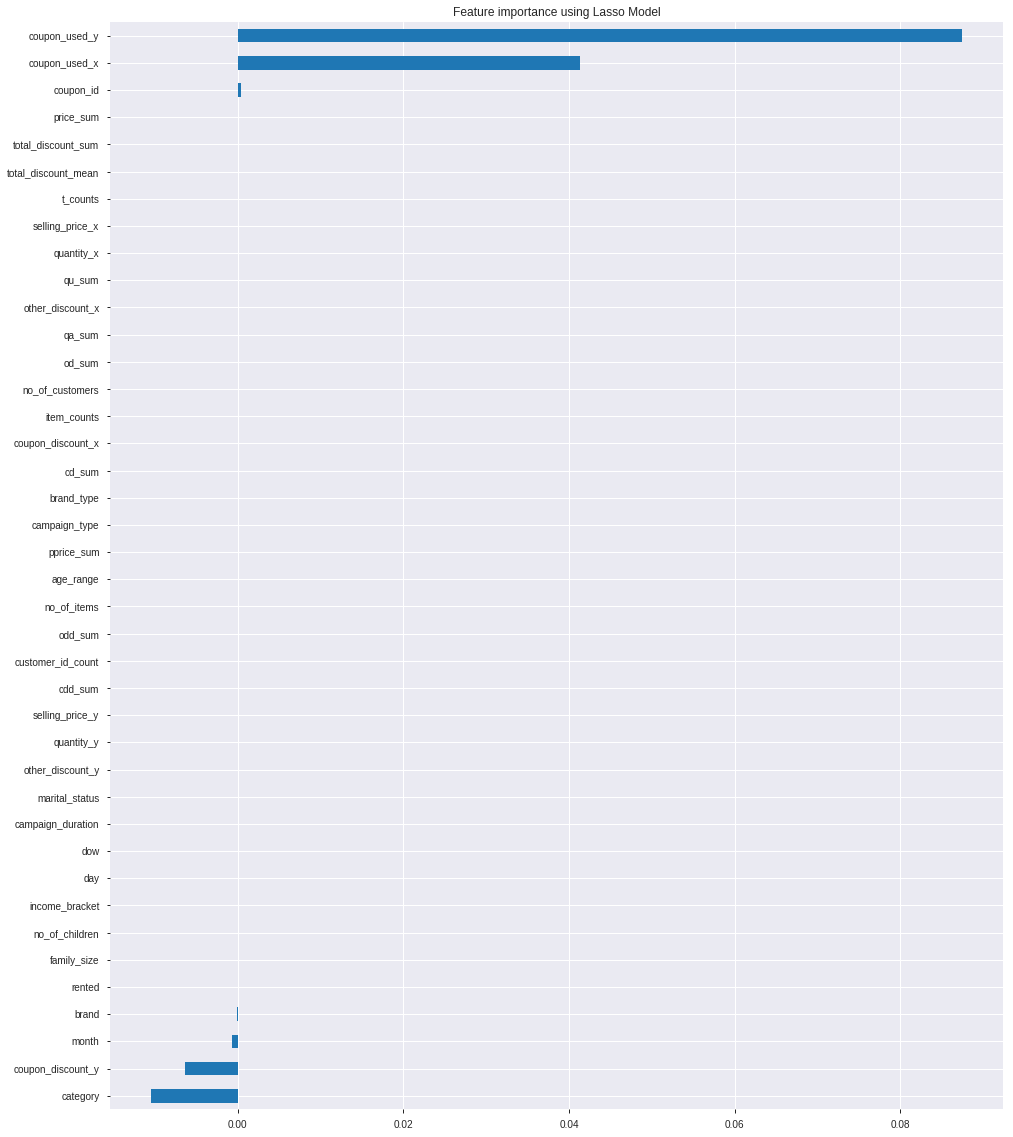

In [59]:
imp_coef = coef.sort_values()
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 20.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

8 columns

columns:['qu_sum', 'pprice_sum', 'qa_sum', 'price_sum', 'total_discount_sum', 'cd_sum', 'odd_sum', 'cdd_sum']

In [60]:
col_names=['qu_sum', 'pprice_sum', 'qa_sum', 'price_sum', 'total_discount_sum', 'cd_sum', 'odd_sum', 'cdd_sum']

In [61]:
x=x[col_names]

In [62]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1990)

In [63]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((108696, 8), (108696,), (46584, 8), (46584,))

# Logistic Regression

In [64]:
LR = LogisticRegression()
LR.fit(x_train,y_train)
y_pred_LR = LR.predict(x_test)
print(classification_report(y_test,y_pred_LR))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79     23383
           1       0.82      0.71      0.76     23201

    accuracy                           0.78     46584
   macro avg       0.78      0.78      0.78     46584
weighted avg       0.78      0.78      0.78     46584



In [65]:
roc_auc_score(y_test,y_pred_LR)
Model = ['Logistic Regression']
ROC_AUC_Accuracy = [roc_auc_score(y_test,y_pred_LR)]

# Naive Bayes

In [66]:
nb = GaussianNB()
nb.fit(x_train,y_train)
y_pred_nb = nb.predict(x_test)
print(roc_auc_score(y_test,y_pred_nb))
Model.append('Naive Bayes')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_nb))

0.5988988093861665


In [67]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.56      0.96      0.71     23383
           1       0.84      0.24      0.38     23201

    accuracy                           0.60     46584
   macro avg       0.70      0.60      0.54     46584
weighted avg       0.70      0.60      0.54     46584



In [68]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'Naive Bayes'],
 [0.7772513390805917, 0.5988988093861665])

# Decision Tree

In [69]:
params = {
    
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':range(1,10),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}

dt = DecisionTreeClassifier()

rs = RandomizedSearchCV(estimator=dt,n_jobs=-1,cv=3,param_distributions=params,scoring='recall')
rs.fit(x,y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best')

In [70]:
dt = DecisionTreeClassifier(**rs.best_params_)
dt.fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)
print(roc_auc_score(y_test,y_pred_dt))
Model.append('Decision Tree')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_dt))

0.8544237091462134


In [71]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84     23383
           1       0.79      0.96      0.87     23201

    accuracy                           0.85     46584
   macro avg       0.87      0.85      0.85     46584
weighted avg       0.87      0.85      0.85     46584



In [72]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'Naive Bayes', 'Decision Tree'],
 [0.7772513390805917, 0.5988988093861665, 0.8544237091462134])

# Random Forest

In [73]:
params = {
    
    'n_estimators':range(10,100,10),
    'criterion':['gini','entropy'],
    'max_depth':range(2,10,1),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}

rf = RandomForestClassifier()

rs = RandomizedSearchCV(estimator=rf,param_distributions=params,cv=5,scoring='recall',n_jobs=-1)
rs.fit(x,y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [74]:
rf = RandomForestClassifier(**rs.best_params_)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
print(roc_auc_score(y_test,y_pred_rf))
Model.append('Random Forest')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_rf))

0.86778998551624


In [75]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     23383
           1       0.87      0.87      0.87     23201

    accuracy                           0.87     46584
   macro avg       0.87      0.87      0.87     46584
weighted avg       0.87      0.87      0.87     46584



In [76]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest'],
 [0.7772513390805917,
  0.5988988093861665,
  0.8544237091462134,
  0.86778998551624])

In [77]:
final_result = pd.DataFrame({'Model':Model,'Accuracy':ROC_AUC_Accuracy})
final_result

,Model,Accuracy
0,Logistic Regression,0.777251
1,Naive Bayes,0.598899
2,Decision Tree,0.854424
3,Random Forest,0.867790
